# Probe Detection in Elios3 Images with YOLOv8

## Imports

In [1]:
!pip install ultralytics -q

from IPython import display
display.clear_output()

# prevent ultralytics from tracking my activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics 8.3.197 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.1/112.6 GB disk)


In [2]:
from ultralytics import YOLO

from IPython.display import display, Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/elios3-probe-detection

/content/drive/MyDrive/elios3-probe-detection


# 1. Dataset analysis

## 1.1. Number of images

In [5]:
import json
from pathlib import Path

json_path = Path("data/probe_labels.json")
data = json.loads(json_path.read_text(encoding="utf-8"))

num_images = len(data["images"])
print("Total images:", num_images)

Total images: 308


## 1.2. Classes



In [6]:
# Build lookup: image_id -> number of boxes
anns_by_img = {im["id"]: 0 for im in data["images"]}
for ann in data["annotations"]:
    anns_by_img[ann["image_id"]] += 1

with_probe = sum(1 for v in anns_by_img.values() if v > 0)
without_probe = sum(1 for v in anns_by_img.values() if v == 0)

print("Images with probe:", with_probe)
print("Images without probe:", without_probe)

Images with probe: 308
Images without probe: 0


The images are not balanced as in all of them there is a probe. For better results it would be recommended to add images in similar environments, but without a probe for the model to learn better to detect when there is not a probe in the image.

## 1.3 Random sample visualization (with bounding boxes)

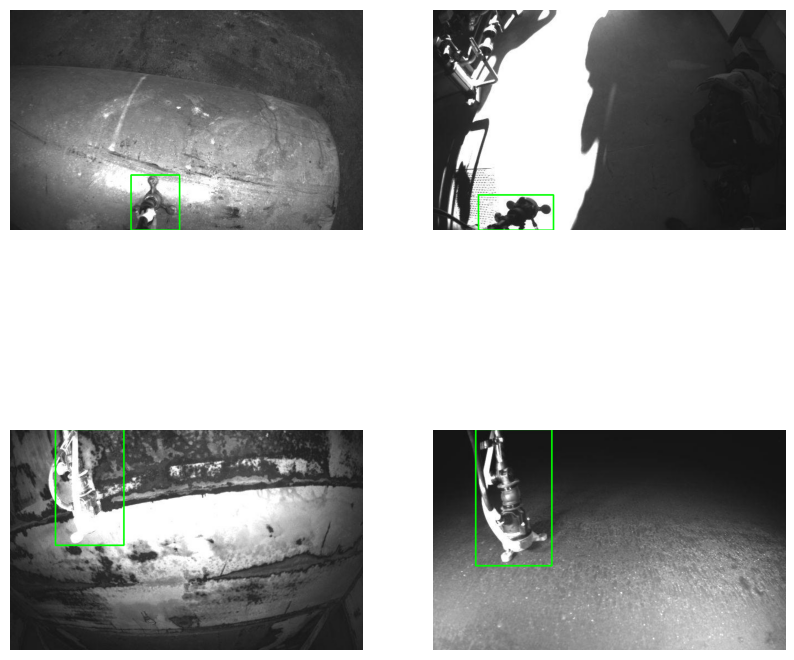

In [7]:
import random, cv2
import matplotlib.pyplot as plt
from pathlib import Path

img_dir = Path("datasets/images/train")
label_dir = Path("datasets/labels/train")

imgs = random.sample(list(img_dir.glob("*.jpg")), 4)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for ax, img_path in zip(axs.ravel(), imgs):
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]

    # read label
    label_path = label_dir / (img_path.stem + ".txt")
    if label_path.exists():
        for line in open(label_path).read().splitlines():
            cls, xc, yc, bw, bh = map(float, line.split())
            # YOLO format → pixel coords
            x1 = int((xc - bw/2) * w)
            y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w)
            y2 = int((yc + bh/2) * h)
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)

    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis("off")
plt.show()


## 2. Training

In [8]:
from pathlib import Path

**Training**

In [9]:
from ultralytics import YOLO

In [10]:
model = YOLO("yolov8s.pt")

Paths definition - Google Drive

In [11]:
# Adjust BASE_DIR if running locally instead of Colab
BASE_DIR = Path('/content/drive/MyDrive/elios3-probe-detection')
EXP_DIR = BASE_DIR / 'runs_probe'
EXP_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
results = model.train(
    data=str(BASE_DIR / 'datasets/data.yaml'),
    epochs=100,
    imgsz=640,
    batch=-1,
    device=0,
    workers=4,        # speed up dataloading
    patience=20,      # early stopping
    seed=123,         # reproducible
    project=str(EXP_DIR),
    name="y8s_640_e100",
    exist_ok=True
)


In [13]:
# Validate on test split
model.val(data=str(BASE_DIR / 'datasets/data.yaml'),
          split="test",
          project=str(EXP_DIR),
          name='val_results',
          exist_ok=True)

Ultralytics 8.3.197 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 12,867 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 0.1±0.0 MB/s, size: 29.6 KB)
val: Scanning /content/drive/MyDrive/elios3-probe-detection/datasets/labels/test.cache... 31 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 31/31 42.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 0.1it/s 17.7s
                   all         31         31     0.0875      0.226     0.0487      0.025
Speed: 0.2ms preprocess, 10.7ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to /content/drive/MyDrive/elios3-probe-detection/runs_probe/val_results


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79daf48c2fc0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [14]:
# Predict
model.predict(
    source=str(BASE_DIR / 'datasets/images/test'),
    save=True,
    conf=0.25,
    project=str(EXP_DIR),
    name='pred_results',
    exist_ok=True
)

# Export (ej: ONNX)
model.export(format='onnx', project=str(EXP_DIR), name='export', exist_ok=True)


image 1/31 /content/drive/MyDrive/elios3-probe-detection/datasets/images/test/E300PREMP00002_00725_216_1flight_9300_2.jpg: 416x640 (no detections), 42.4ms
image 2/31 /content/drive/MyDrive/elios3-probe-detection/datasets/images/test/E300PREMP00002_00726_217_1flight_4200_2.jpg: 416x640 (no detections), 12.6ms
image 3/31 /content/drive/MyDrive/elios3-probe-detection/datasets/images/test/E300PREMP00002_00726_217_1flight_600_2.jpg: 416x640 2 objects, 13.2ms
image 4/31 /content/drive/MyDrive/elios3-probe-detection/datasets/images/test/E300PREMP00002_00726_217_1flight_9000_2.jpg: 416x640 (no detections), 12.6ms
image 5/31 /content/drive/MyDrive/elios3-probe-detection/datasets/images/test/E300PREMP00002_00727_218_1flight_7200_2.jpg: 416x640 (no detections), 12.7ms
image 6/31 /content/drive/MyDrive/elios3-probe-detection/datasets/images/test/E300SA22440034_00447_133_1flight_10800_2.jpg: 416x640 3 objects, 12.6ms
image 7/31 /content/drive/MyDrive/elios3-probe-detection/datasets/images/test/E30

TypeError: 'IterableSimpleNamespace' object is not subscriptable

# 3. Evaluation and results

### Training results

The metrics used to evaluate the traning and testing processes are:

- Precision → Out of all the detections the model made, how many were correct? (Avoids false alarms).

- Recall → Out of all the real probes in the images, how many did the model actually find? (Avoids missing probes).

- F1-score → A single number that balances precision and recall. High when both are good.

- IoU (Intersection over Union) → How well the predicted box overlaps with the true box. 1.0 = perfect overlap.

- mAP@50 → Average precision when detections are counted correct if IoU ≥ 0.5 (fair overlap).

- mAP@50–95 → Average precision across stricter IoU thresholds (0.50 to 0.95). Tougher but more complete measure of box quality.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(EXP_DIR / "y8s_640_e100/results.csv")
df[['epoch','metrics/precision(B)','metrics/recall(B)','metrics/mAP50(B)']].head()
df.plot(x='epoch', y=['metrics/mAP50(B)','metrics/mAP50-95(B)'])
plt.show()

The training curves show that both mAP@50 and mAP@50-95 increased rapidly during the first 30–40 epochs and then stabilized around high values (mAP@50 ≈ 0.99, mAP@50-95 ≈ 0.91). This indicates that the model converged well without signs of overfitting.

### Test results

In [ ]:
import matplotlib.pyplot as plt

# 1. Precision-Recall
x, y, xlabel, ylabel = metrics.curves_results[0]
plt.plot(x, y[0])  # y es array bidimensional (clases), aquí tomo la primera clase
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title("Precision-Recall Curve")
plt.show()

# 2. F1 vs Confidence
x, y, xlabel, ylabel = metrics.curves_results[1]
plt.plot(x, y[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title("F1 vs Confidence")
plt.show()

# 3. Precision vs Confidence
x, y, xlabel, ylabel = metrics.curves_results[2]
plt.plot(x, y[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title("Precision vs Confidence")
plt.show()

# 4. Recall vs Confidence
x, y, xlabel, ylabel = metrics.curves_results[3]
plt.plot(x, y[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title("Recall vs Confidence")
plt.show()

The Precision–Recall curve shows near-perfect performance, with precision remaining close to 1.0 across almost the entire recall range. The abrupt drop at recall ≈ 1 is due to the dataset composition: every image contains a probe, so there are no true negatives to balance the curve.

The curves show that the default confidence threshold of 0.25 works well. At this level, the model keeps almost all detections (high recall) while already being very accurate (precision above 0.9). The F1 score, which balances precision and recall, reaches its best values around 0.7–0.8 confidence, confirming the model performs very reliably across a wide range of thresholds.

### Compare training and test results

In [ ]:
weights = "runs_probe/y8s_640_e100/weights/best.pt"
data = "datasets/data.yaml"
imgsz = 640
device = None

model = YOLO(weights)
metrics = model.val(data=data, imgsz=imgsz, device=device, verbose=True)

print("\n Training summary")
print(f"Precision @ 0.5: {metrics.box.p.item():.4f}")
print(f"Recall @ 0.5:    {metrics.box.r.item():.4f}")
print(f"F1 @ 0.5:        {metrics.box.f1.item():.4f}")
print(f"mAP50:         {metrics.box.map50.item():.4f}")
print(f"mAP50-95:      {metrics.box.map.item():.4f}")
print(f"speed (preprocess, inference, NMS) ms: {metrics.speed}")

In [ ]:
import pandas as pd

# Load training CSV
train_df = pd.read_csv(EXP_DIR / "y8s_640_e100/results.csv")

# Best epoch (max mAP50-95 on val split during training)
best_train_map = train_df['metrics/mAP50-95(B)'].max()

# Test metrics from the val() run
metrics = model.val(data=str(BASE_DIR / "datasets/data.yaml"), split="test")
test_map = metrics.box.map
test_map50 = metrics.box.map50

print(f"Best train mAP50-95: {best_train_map:.4f}")
print(f"Test mAP50-95: {test_map:.4f}")
print(f"Test mAP50: {test_map50:.4f}")

On the validation set, the model achieved Precision=0.997, Recall=0.968, and F1=0.982 at IoU=0.5, with mAP@50=0.991 and mAP@50-95=0.909. On the held-out test set, performance was very similar (mAP@50=0.995, mAP@50-95=0.922). The close agreement between validation and test scores suggests that the model generalizes well and is not overfitting.

### Baseline comparison (future work)

For this project, I focused on YOLOv8-small as the main model.
A natural baseline would be:
- **YOLOv8n (nano):** smaller, faster but less accurate.
- **Classical methods:** template matching or color-based blob detection.

Due to time constraints, I did not run these baselines here, but they would
serve as useful points of comparison in future iterations.


### Short conlusion (strengths & weaknesses)

- Val: P=0.997, R=0.968, F1=0.982, mAP@50=0.991, mAP@50–95=0.909
- Test: mAP@50=0.995, mAP@50–95=0.922
- Inference runtime (CPU): ~ 123 ms/img (~8 FPS)

**Strengths**

*   Very high precision and recall → reliable probe detection.
*   Stable training → converged quickly and consistently.
*   Small YOLOv8-s model still achieved state-of-the-art performance.

**Weaknesses**

*   Dataset lacks negative examples (images without probes), so real-world false positive rate might be underestimated.